In [1]:
import pandas as pd

df=pd.read_json('https://gist.githubusercontent.com/farhaan-settyl/ecf9c1e7ab7374f18e4400b7a3d2a161/raw/f94652f217eeca83e36dab9d08727caf79ebdecf/dataset.json')

In [2]:
df.head()

,externalStatus,internalStatus
0,PORT OUT,Port Out
1,TERMINAL IN,Inbound Terminal
2,PORT IN,Port In
3,Vessel departure from first POL (Vessel name :...,Departure
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival


In [3]:
df.duplicated().sum()

1114

In [4]:
1222-1114


108

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   externalStatus  1222 non-null   object
 1   internalStatus  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [6]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1217     True
1218     True
1219     True
1220     True
1221     True
Length: 1222, dtype: bool

In [7]:
df.isna().sum()

externalStatus    0
internalStatus    0
dtype: int64

In [8]:
val=df.drop_duplicates(keep='last')
df.drop_duplicates(keep='first',inplace=True)

In [9]:
df['internalStatus'].value_counts()

internalStatus
Loaded on Vessel            49
Departure                   16
Arrival                     13
Outbound Terminal            9
Unloaded on Vessel           6
Empty Container Released     3
Inbound Terminal             2
Empty Return                 2
Gate Out                     2
Port Out                     1
Port In                      1
Gate In                      1
On Rail                      1
Off Rail                     1
In-transit                   1
Name: count, dtype: int64

In [10]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

df['externalStatus'] = df['externalStatus'].apply(lambda x: x.lower())
df['externalStatus'] = df['externalStatus'].apply(lambda x: re.sub(r'[^\w\s\d]', '', x))
# df['externalStatus'] = df['externalStatus'].apply(lambda x: re.sub(r'[0-9]', '', x))
val['externalStatus']= val['externalStatus'].apply(lambda x :x.lower())
val['externalStatus'] = val['externalStatus'].apply(lambda x: re.sub(r'[^\w\s\d]', '', x))

label_encoder = LabelEncoder()



df['Output'] = label_encoder.fit_transform(df['internalStatus'])
val['Output']=label_encoder.transform(val['internalStatus'])

In [11]:
import numpy as np
np.max([len(i) for i in df['externalStatus']])

68

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Tokenize and pad text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['externalStatus'])
X = tokenizer.texts_to_sequences(df['externalStatus'])
X = pad_sequences(X, maxlen=100)
x_test = tokenizer.texts_to_sequences(val['externalStatus'])
x_test = pad_sequences(x_test, maxlen=100)

2024-04-07 17:09:43.172631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 17:09:43.175847: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 17:09:43.179891: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 17:09:43.223186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 17:09:45.125515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [47]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=500, output_dim=130, ))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(.5))
# model.add(LSTM(128,return_sequences=True))

# model.add(LSTM(64,return_sequences=True))

model.add(LSTM(32))

model.add(Dense(15, activation='softmax'))  # Adjust NUM_CLASSES based on the number of unique labels

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X, df['Output'],batch_size=4,validation_data=(x_test,val['Output']) ,epochs=50,callbacks=[early_stopping])



Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2772 - loss: 2.3986 - val_accuracy: 0.4537 - val_loss: 1.8915
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4795 - loss: 1.9373 - val_accuracy: 0.4537 - val_loss: 1.8628
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4343 - loss: 1.7820 - val_accuracy: 0.4537 - val_loss: 1.8506
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5361 - loss: 1.6754 - val_accuracy: 0.4537 - val_loss: 1.8450
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4598 - loss: 1.8950 - val_accuracy: 0.4537 - val_loss: 1.8378
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4872 - loss: 1.7768 - val_accuracy: 0.4537 - val_loss: 1.8241
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4008 - loss: 1.9527 - val_accuracy: 0.4537 - val_loss: 1.7884
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4595 - loss: 1.6579 - val_accuracy: 0.4537 - v

In [48]:
from keras.utils import plot_model
import pydot

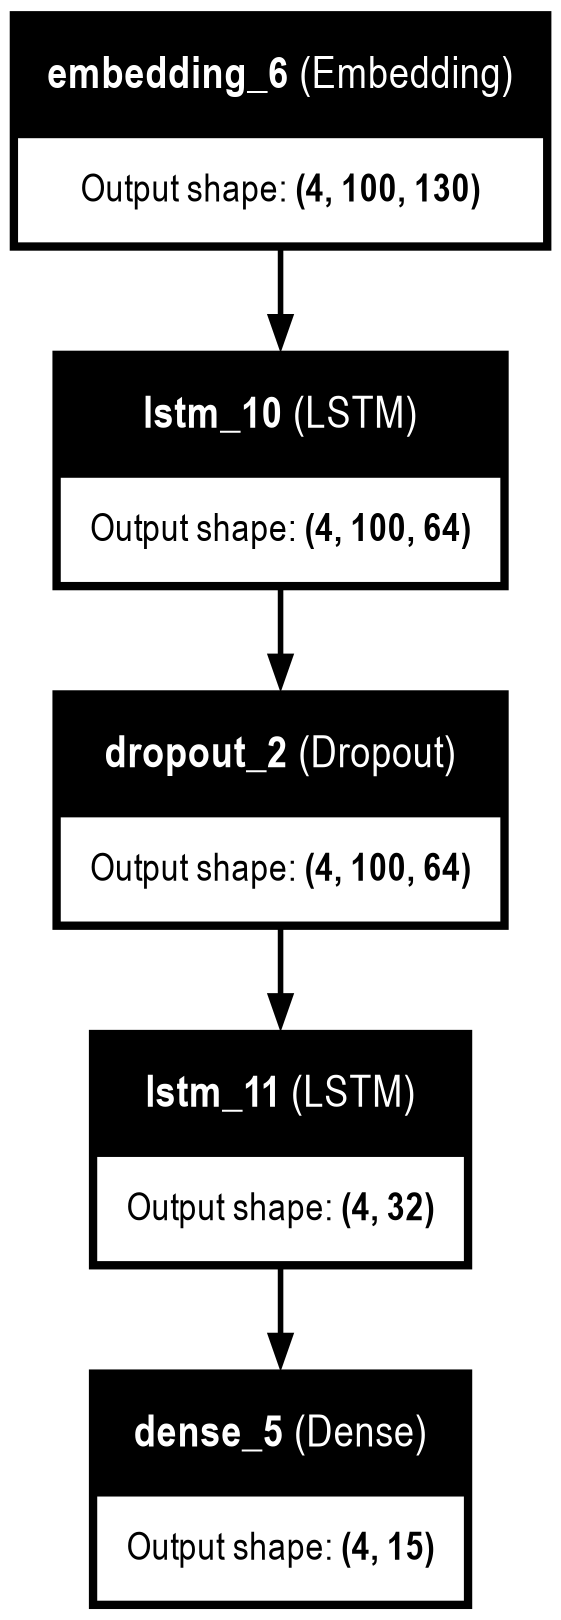

In [49]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [50]:

def predict_internal_status(model, tokenizer, user_input):
    user_input.lower()
    re.sub(r'[^\w\s]', '', user_input)
    # Tokenize the user input
    import numpy as np
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    # Pad sequences to the same length as training data
    user_input_sequence_padded = pad_sequences(user_input_sequence, maxlen=130)

    # Make predictions
    predictions = model.predict(user_input_sequence_padded)

    # Get the predicted class (internal status)
    predicted_class = np.argmax(predictions)
    predicted_class1 = label_encoder.inverse_transform([predicted_class])

    return predicted_class1[0],np.max(predictions)
    # return predicted_class

In [51]:
predict_internal_status(model,tokenizer,' toll plazza passed')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


('Departure', 0.34254366)

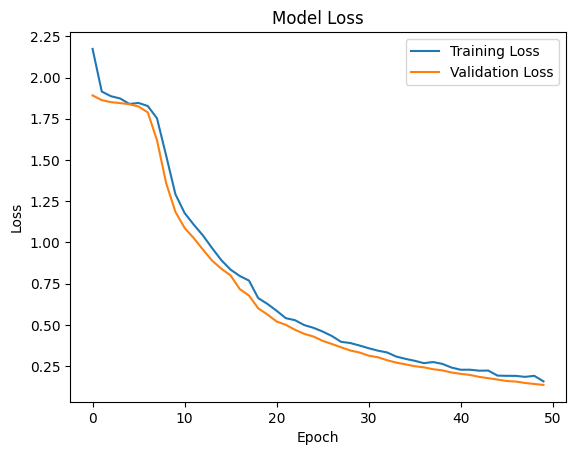

In [52]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_loss(history)

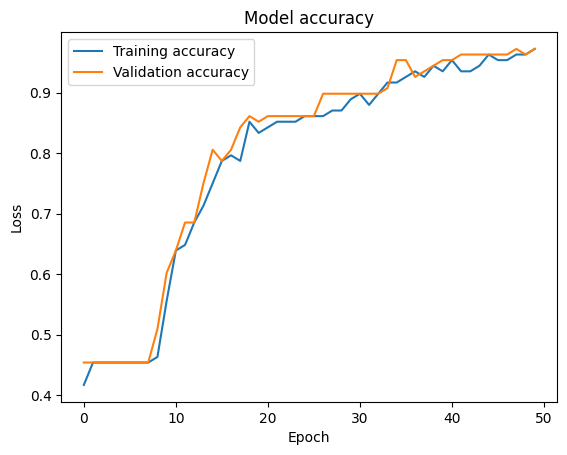

In [54]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_accuracy(history)

In [55]:
model.save("model.keras")

In [56]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [57]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)